In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
#LOading the dataset
train=pd.read_csv("Train.csv")
test=pd.read_csv("Test.csv")


**Cleaning and Exploratory Data analysis**





In [49]:
train.head()

# check for categorical attributes
cat_col = []
for x in train.dtypes.index:
    if train.dtypes[x] == 'object':
        cat_col.append(x)
cat_col
cat_col.remove('Item_Identifier')
cat_col.remove('Outlet_Identifier')
cat_col
for col in cat_col:
    print(col)
    print(train[col].value_counts())
    print()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Outlet_Size
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int6

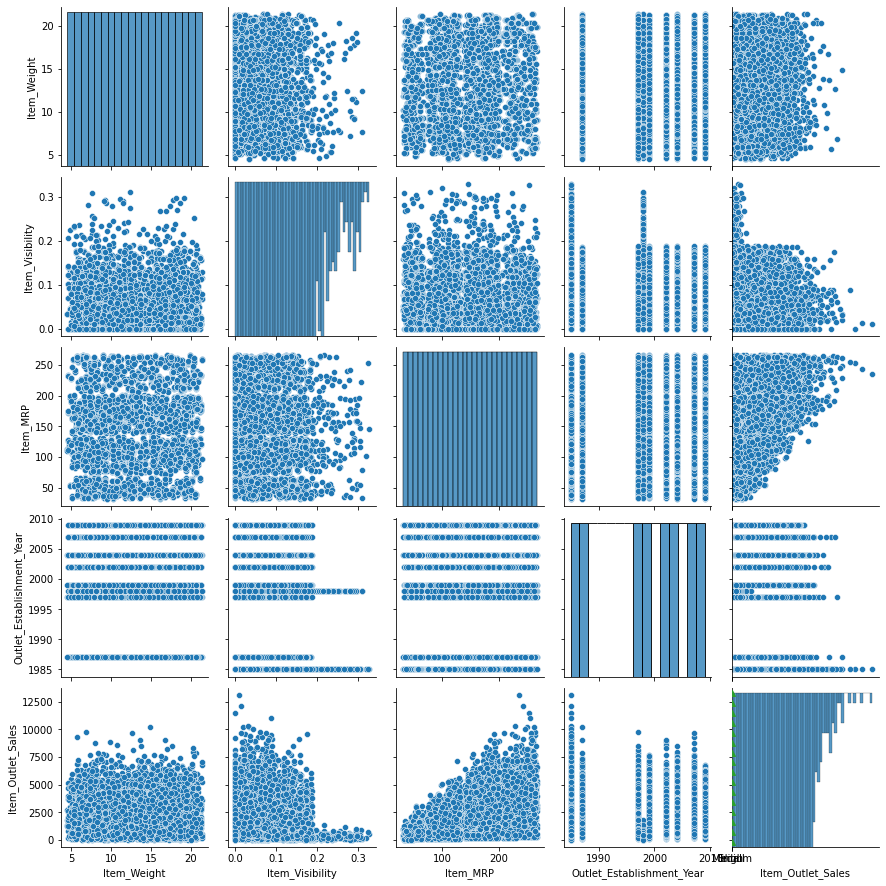

In [50]:
#checking the data points
sns.pairplot(train)
sns.boxplot(x="Outlet_Size",y="Item_Outlet_Sales",data=train,showmeans=True)
sns.boxplot(x="Item_Weight",y="Item_Type",data=train,showmeans=True)

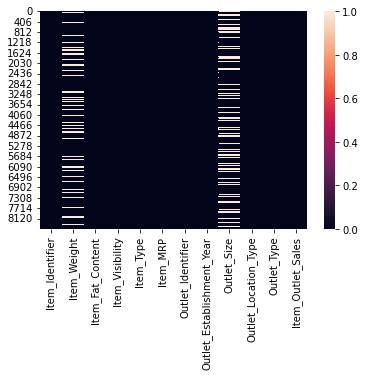

In [51]:
#cheking for null values
sns.heatmap(train.isnull())
#unique types of food content
types=train["Item_Type"].unique()
means=[]

#calculating mean for data cleaning of item weights
for i in types:
  a=[]
  n=0
  for m in train["Item_Type"]:
    if i==m:
      if (train["Item_Weight"].notnull())[n] == True:
        a.append(train["Item_Weight"][n])
    n=n+1
  means.append(np.mean(a))  
#defining change function to change cols
def change(cols):
  Item_weight=cols[0]
  Item_Type=cols[1]
  if pd.isnull(Item_weight):
    for m in range(0,16):
      if Item_Type==types[m]:
        return means[m]
  
  else:
    return Item_weight


#changing item weights
train["Item_Weight"]=train[['Item_Weight','Item_Type']].apply(change,axis=1)


In [52]:
outlet_size_mode = train.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
outlet_size_mode

miss_bool = train['Outlet_Size'].isnull()
train.loc[miss_bool, 'Outlet_Size'] = train.loc[miss_bool, 'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

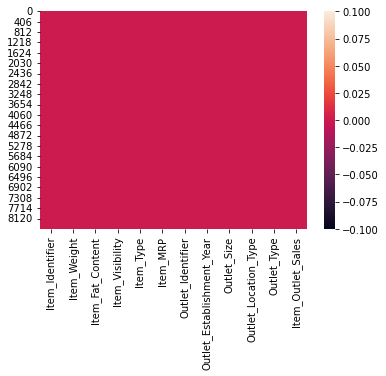

In [53]:
sns.heatmap(train.isnull())

In [54]:
# replace zeros with mean
train.loc[:, 'Item_Visibility'].replace([0], [train['Item_Visibility'].mean()], inplace=True)

In [55]:
# combine item fat content
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})
train['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [56]:
train['New_Item_Type'] = train['Item_Identifier'].apply(lambda x: x[:2])
train['New_Item_Type'] = train['New_Item_Type'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})
train['New_Item_Type'].value_counts()
train.loc[train['New_Item_Type']=='Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'
train['Item_Fat_Content'].value_counts()
train['Outlet_Years'] = 2013 - train['Outlet_Establishment_Year']


**Label Encoding**

In [57]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['Outlet'] = le.fit_transform(train['Outlet_Identifier'])
cat_col = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'New_Item_Type']
for col in cat_col:
    train[col] = le.fit_transform(train[col].astype(str))
train = pd.get_dummies(train, columns=['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'New_Item_Type'])
train.head()


,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,Outlet_Years,Outlet,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Outlet_Size_0,Outlet_Size_1,Outlet_Size_2,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Type_0,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,New_Item_Type_0,New_Item_Type_1,New_Item_Type_2
0,FDA15,9.30,0.016047,4,249.8092,OUT049,1999,3735.1380,14,9,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
1,DRC01,5.92,0.019278,14,48.2692,OUT018,2009,443.4228,4,3,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0
2,FDN15,17.50,0.016760,10,141.6180,OUT049,1999,2097.2700,14,9,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
3,FDX07,19.20,0.066132,6,182.0950,OUT010,1998,732.3800,15,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0
4,NCD19,8.93,0.066132,9,53.8614,OUT013,1987,994.7052,26,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1


MODEL Training

In [58]:
y = train['Item_Outlet_Sales']
train.drop(['Outlet_Establishment_Year', 'Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'],axis=1,inplace=True)
X=train

In [59]:

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
def train(model, X, y):
    # train the model
    model.fit(X, y)
    
    # predict the training set
    pred = model.predict(X)
    
    # perform cross-validation
    cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    cv_score = np.abs(np.mean(cv_score))
    
    print("Model Report")
    print("MSE:",mean_squared_error(y,pred))
    print("CV Score:", cv_score)

Model Report
MSE: 1271056.4915669304
CV Score: 1276941.8244480134


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pi

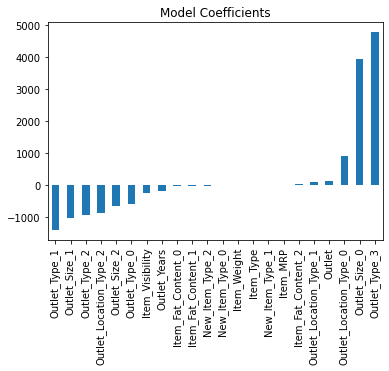

In [61]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
model = LinearRegression(normalize=True)
train(model, X, y)
coef = pd.Series(model.coef_, X.columns).sort_values()
coef.plot(kind='bar', title="Model Coefficients")

Model Report
MSE: 1621880.3926406114
CV Score: 1625209.7137075644


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipel

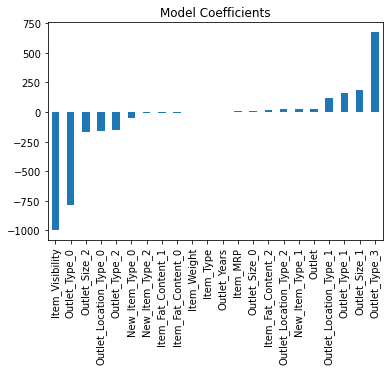

In [62]:
model = Ridge(normalize=True)
train(model, X, y)
coef = pd.Series(model.coef_, X.columns).sort_values()
coef.plot(kind='bar', title="Model Coefficients")